# 数据预处理

In [24]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [25]:
# 返回正则匹配的文件名
def findFiles(path): return glob.glob(path)

In [26]:
print(findFiles("nameData/names/*.txt"))

['nameData/names\\Arabic.txt', 'nameData/names\\Chinese.txt', 'nameData/names\\Czech.txt', 'nameData/names\\Dutch.txt', 'nameData/names\\English.txt', 'nameData/names\\French.txt', 'nameData/names\\German.txt', 'nameData/names\\Greek.txt', 'nameData/names\\Irish.txt', 'nameData/names\\Italian.txt', 'nameData/names\\Japanese.txt', 'nameData/names\\Korean.txt', 'nameData/names\\Polish.txt', 'nameData/names\\Portuguese.txt', 'nameData/names\\Russian.txt', 'nameData/names\\Scottish.txt', 'nameData/names\\Spanish.txt', 'nameData/names\\Vietnamese.txt']


In [27]:
import unicodedata
import string
# "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"
all_letters = string.ascii_letters + " .,;'"  # 确定char的索引
n_letters = len(all_letters)  # 决定one-hot编码长度


In [28]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
# 就是把很奇怪的文字 转化为普通的 letters
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [33]:
# Build the category_lines dictionary, a list of names per language
# key为语言，value为名字构成的列表
category_lines = {}
# 语言列表
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('nameData/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# 数据转化为Tensor

In [34]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# 建模

In [35]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [36]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [39]:
input = lineToTensor('Ren')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9011, -2.8734, -2.8536, -2.9168, -2.9649, -2.9625, -2.8253, -2.9885,
         -2.8682, -2.8880, -2.8741, -2.8928, -2.8890, -2.8874, -2.9366, -2.9051,
         -2.8405, -2.7812]], grad_fn=<LogSoftmaxBackward>)


# 工具函数

In [42]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


In [54]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)        # 随机选择语言
    line = randomChoice(category_lines[category])  # 随机选择姓名
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)  # 语言的一维索引向量
    line_tensor = lineToTensor(line)  # 三维向量
    return category, line, category_tensor, line_tensor

for i in range(1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    print('category_tensor =', category_tensor, '/ line_tensor =', line_tensor.size())

category = Irish / line = Quirke
category_tensor = tensor([8]) / line_tensor = torch.Size([6, 1, 57])


# 训练

In [56]:
criterion = nn.NLLLoss()

In [58]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    # 每一个example执行完毕后，返回类别与损失
    return output, loss.item()

In [59]:
import time
import math

n_iters = 100000   # 随机采样10万次
print_every = 5000 # 没5000个样本后 执行一次测试
plot_every = 1000  # 每1000个样本的损失和



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    # 语言，名字，索引，nameTensor
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        # 返回语言，索引
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.0981 Tsang / Chinese ✓
10000 10% (0m 18s) 2.3958 Nevin / Scottish ✗ (Irish)
15000 15% (0m 26s) 1.4878 Niemczyk / Polish ✓
20000 20% (0m 34s) 1.9886 Borde / French ✓
25000 25% (0m 43s) 2.1500 Murphy / Czech ✗ (Scottish)
30000 30% (0m 51s) 2.1931 Blades / Portuguese ✗ (Greek)
35000 35% (0m 59s) 2.0996 Grose / Scottish ✗ (English)
40000 40% (1m 8s) 3.4153 Bosch / Scottish ✗ (German)
45000 45% (1m 16s) 1.1222 Amari / Arabic ✓
50000 50% (1m 24s) 0.8837 Azarola / Spanish ✓
55000 55% (1m 32s) 0.4445 Yim / Korean ✓
60000 60% (1m 41s) 1.2771 Duncan / Scottish ✓
65000 65% (1m 49s) 3.5340 Procter / French ✗ (English)
70000 70% (1m 58s) 0.4034 Kremlacek / Czech ✓
75000 75% (2m 6s) 0.0488 Malinowski / Polish ✓
80000 80% (2m 14s) 0.7370 Oomen / Dutch ✓
85000 85% (2m 22s) 0.8363 Close / Greek ✓
90000 90% (2m 31s) 1.1489 Breisacher / German ✓
95000 95% (2m 39s) 0.2761 Lepekhin / Russian ✓
100000 100% (2m 48s) 0.7944 Eoin / Irish ✓


# 结果评估

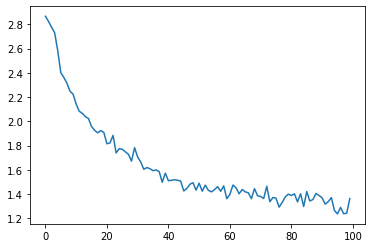

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

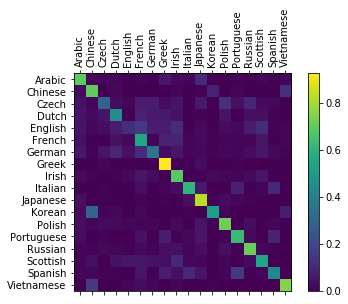

In [62]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# 用户预测

In [68]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Lily')
predict('Jackson')
predict('Satoshi')


> Lily
(-1.12) English
(-1.48) Irish
(-2.02) French

> Jackson
(-0.49) Scottish
(-1.59) Russian
(-2.30) English

> Satoshi
(-0.54) Japanese
(-1.80) Arabic
(-2.35) Polish
